In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
client

Client Scheduler: tcp://10.148.0.40:8786 Dashboard: http://10.148.0.40:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


# Read SST nc_dataset

_____


In [4]:
data_dir = '/home1/scratch/xyu/mit_nc_SST/'
filenames = sorted(glob(data_dir+'SST_*.nc'))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[607:1000]
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
    
grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=True)
ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds['SST'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SST'].isel(face=1).nbytes / 1e9))

Number of files available: 6459
Number of files processed: 6459
CPU times: user 38 s, sys: 17.5 s, total: 55.5 s
Wall time: 57.2 s
<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 6459)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 

# Make a snapshot for each face

____


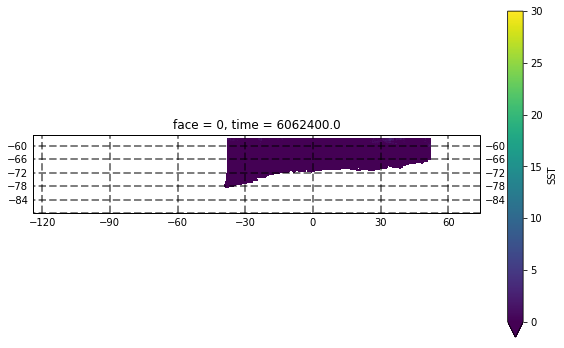

In [13]:
# plot one figure to check lon/lat treatment
import cartopy.crs as ccrs
from cmocean import cm

eta = ds['SST'].isel(face=0, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)

eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False


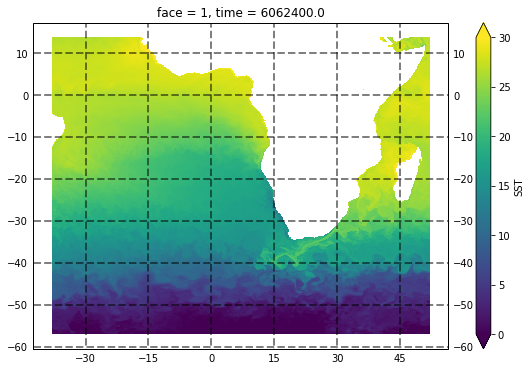

In [14]:
eta = ds['SST'].isel(face=1, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

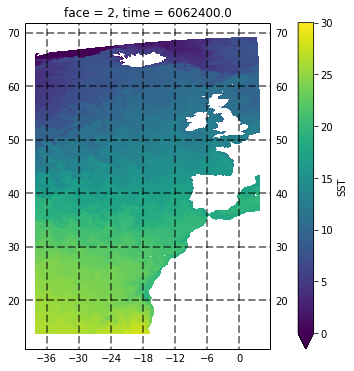

In [42]:
eta = ds['SST'].isel(face=2, time=100, i=slice(0,2000), j=slice(0,4000)) ###############

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

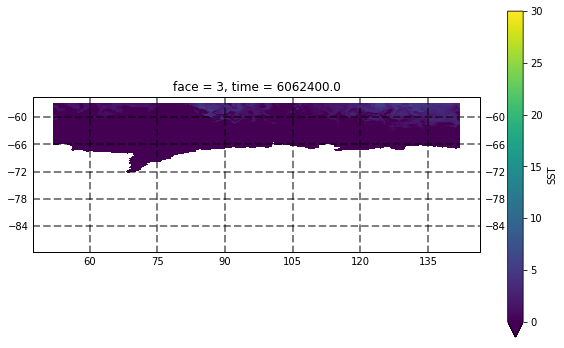

In [16]:
eta = ds['SST'].isel(face=3, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

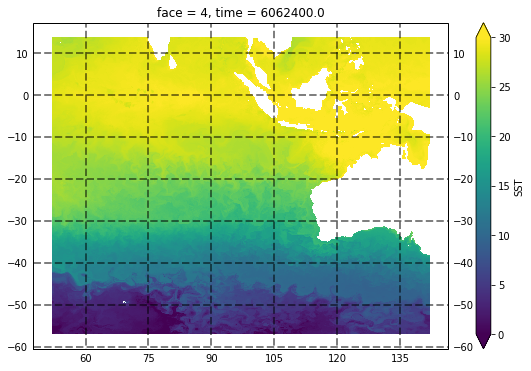

In [17]:
eta = ds['SST'].isel(face=4, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

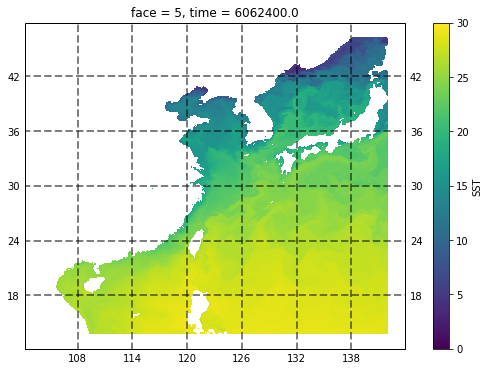

In [36]:
eta = ds['SST'].isel(face=5, time=100, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

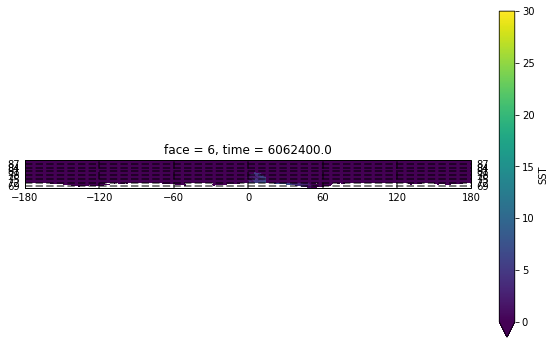

In [20]:
eta = ds['SST'].isel(face=6, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

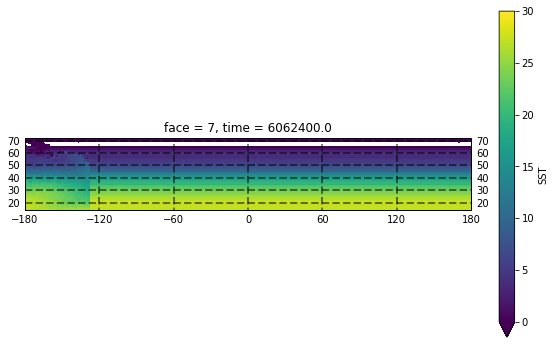

In [21]:
eta = ds['SST'].isel(face=7, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

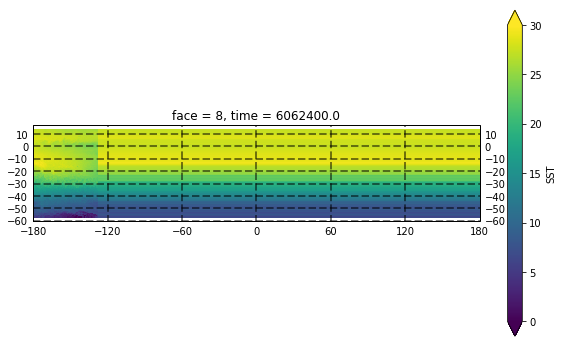

In [23]:
eta = ds['SST'].isel(face=8, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

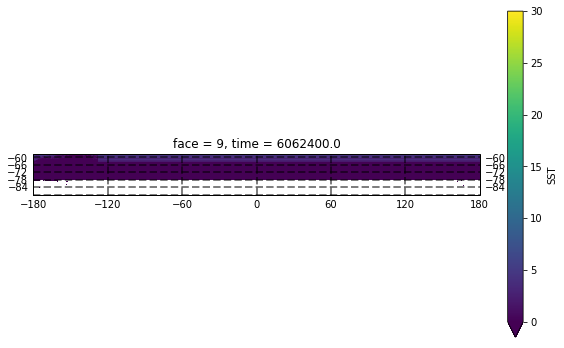

In [24]:
eta = ds['SST'].isel(face=9, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

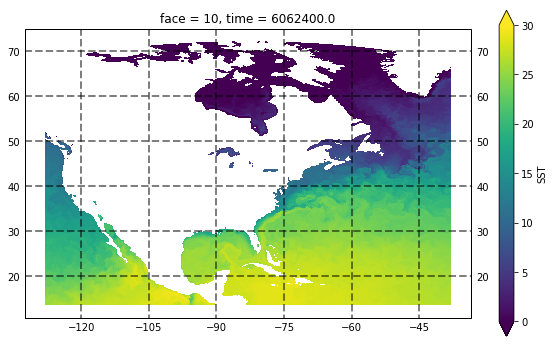

In [26]:
eta = ds['SST'].isel(face=10, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

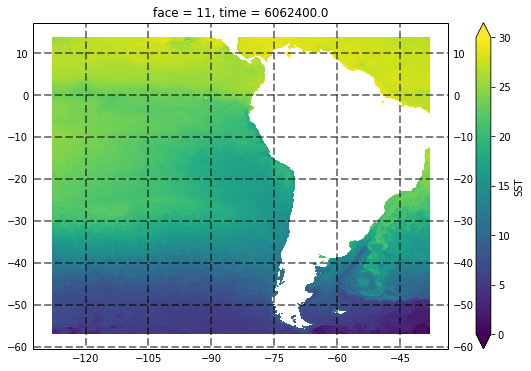

In [27]:
eta = ds['SST'].isel(face=11, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

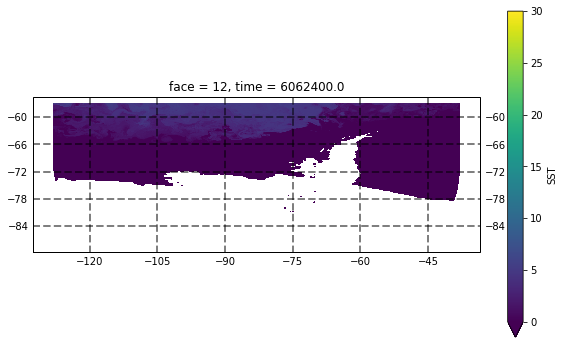

In [28]:
eta = ds['SST'].isel(face=12, time=100)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

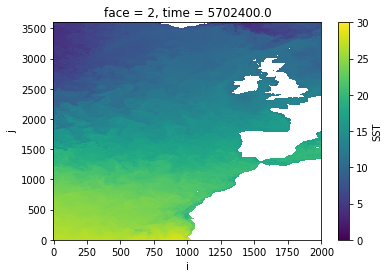

In [41]:
ds['SST'].isel(face=2, time=0, i=slice(0,2000), j=slice(0,3600)).plot(vmin=0, vmax=30)

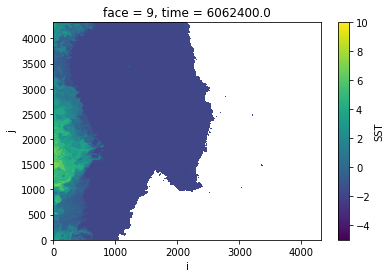

In [46]:
ds['SST'].isel(face=9, time=100).plot(vmin=-5, vmax=10)

# Make movies

____


## face 1


In [ ]:
## southen Africa ##

face = 1
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST']
    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [ ]:
%time results = compute(*values, get=client.get)

# face 2

In [5]:
#### Western EU ####

face = 2
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST'].isel(i=slice(0,2000), j=slice(0,4000))

    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [6]:
%time results = compute(*values, get=client.get)

CPU times: user 21 s, sys: 1.58 s, total: 22.6 s
Wall time: 35min 12s


# face 4

In [7]:
## Western Australia

face = 4
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST']
    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [8]:
%time results = compute(*values, get=client.get)

CPU times: user 24.1 s, sys: 1.54 s, total: 25.6 s
Wall time: 1h 11min 34s


# face 5

In [9]:
#### China ####

face = 5
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST'].isel(i=slice(2500,4320), j=slice(0,2000))
    # eta = ds['SST'].isel(face=5, time=100, i=slice(2500,4320), j=slice(0,2000))


    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [10]:
%time results = compute(*values, get=client.get)

CPU times: user 16.9 s, sys: 1.1 s, total: 18 s
Wall time: 20min 34s


# face 10

In [11]:
# USA #

face = 10
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST']
    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [12]:
%time results = compute(*values, get=client.get)

CPU times: user 22 s, sys: 1.44 s, total: 23.4 s
Wall time: 1h 12min 39s


# face 11

In [13]:
# South America #

face = 11
vmin, vmax = 0., 30.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SST']
    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SST_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SST %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(0, 6459)


In [14]:
%time results = compute(*values, get=client.get)

CPU times: user 22 s, sys: 1.33 s, total: 23.3 s
Wall time: 1h 13min 3s


In [15]:
client.restart()

Client Scheduler: tcp://10.148.0.40:8786 Dashboard: http://10.148.0.40:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB
